# Viscous free-fall metamodel

In the following example we are going to create a metamodel of the fall of a solid in a viscous fluid:

$$m \frac{\delta v}{\delta t} = - m g - c v$$

For a viscous fluid the atitude z admits an explicit solution:

$$z(t) = z_0 + v_{inf} t + \tau (v_0 - v_{inf})(1 - e^{-\frac{t}{\tau}}) \forall t \in [0, t_{max}] $$

With:
- $z$ the altitude above the surface $[m]$
- $z_0$ the initial altitude $[m]$
- $g$ the gravitational acceleration $[m.s^{-2}]$
- $m$ the mass $[kg]$
- $c$ the linear drag coefficient $[kg.s^{-1}]$
- $v_0$ the initial speed (upward) $[m.s^{-1}]$
- $t$ the time $[s]$
- $v_{inf}=-\frac{m g}{c}$ the limit speed $[m.s^{-1}]$
- $\tau=\frac{m}{c}$ time caracteristic $[s]$


The parameters $z_0$, $v_0$, $m$ and $c$ are probabilistic:
- $z_0 \sim \mathcal{U}(100, 150)$
- $v_0 \sim \mathcal{N}(55, 10)$
- $m \sim \mathcal{N}(80, 8)$
- $c \sim \mathcal{U}(0, 30)$

In [11]:
from __future__ import print_function
import openturns as ot
from numpy import linspace, exp, maximum

In [12]:
# Some parameters
tmin=0.0 # Date minimale
tmax=12. # Date maximale
gridsize=100 # Nombre de pas de temps
mesh = ot.IntervalMesher([gridsize-1]).build(ot.Interval(tmin, tmax))

In [13]:
# model function
def AltiFunc(X):
    g  = 9.81
    z0 = X[0]
    v0 = X[1]
    m  = X[2]
    c  = X[3]
    zmin = X[4]
    tau=m/c
    vinf=-m*g/c
    t = linspace(tmin,tmax,gridsize)
    z=z0+vinf*t+tau*(v0-vinf)*(1-exp(-t/tau))
    z=maximum(z,zmin)
    return ot.Field(mesh, [[zeta] for zeta in z])
alti = ot.PythonPointToFieldFunction(5, 1, 1, AltiFunc)

In [14]:
# Creation of the input distribution
distZ0 = ot.Uniform(100.0, 150.0)
distV0 = ot.Normal(55.0, 10.0)
distM = ot.Normal(80.0, 8.0)
distC = ot.Uniform(0.0, 30.0)
distZmin = ot.Dirac([0.0])
distX = ot.ComposedDistribution([distZ0, distV0, distM, distC, distZmin])

In [15]:
# Sample the model
size = 10
inputSample = distX.getSample(size)
outputSample = alti(inputSample)

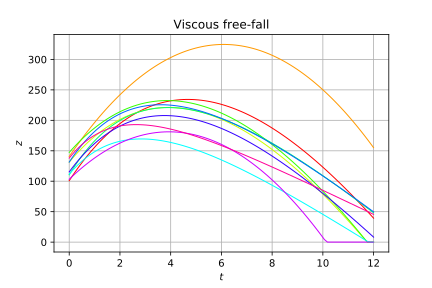

In [16]:
# Draw some curves
graph = outputSample.drawMarginal(0)
graph.setTitle('Viscous free-fall')
graph.setXTitle(r'$t$')
graph.setYTitle(r'$z$')
graph.setColors([ot.Drawable.ConvertFromHSV(i * (360.0/size), 1.0, 1.0) for i in range(len(graph.getDrawables()))])
graph

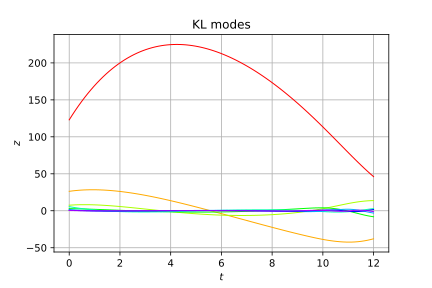

In [17]:
# Compute the KL decomposition of the output
size = 2000
ot.RandomGenerator.SetSeed(0)
inputSample = distX.getSample(size)
outputSample = alti(inputSample)
algo = ot.KarhunenLoeveSVDAlgorithm(outputSample, 1.0e-6)
algo.run()
KLResult = algo.getResult()
scaledModes = KLResult.getScaledModesAsProcessSample()
graph = scaledModes.drawMarginal(0)
graph.setTitle('KL modes')
graph.setXTitle(r'$t$')
graph.setYTitle(r'$z$')
graph

In [18]:
# Meta-model
# Here we have to suppress the Dirac component
alti = ot.PointToFieldConnection(alti, ot.SymbolicFunction(["z0", "v0", "m", "c"], ["z0", "v0", "m", "c", "0.0"]))
inputSampleChaos = inputSample.getMarginal(range(4))

postProcessing = ot.KarhunenLoeveLifting(KLResult)
outputSampleChaos = KLResult.project(outputSample)

size = 10
validationInputSample = distX.getMarginal(range(4)).getSample(size)
validationOutputSample = alti(validationInputSample)

In [19]:
# First, using the most basic interface
algo = ot.FunctionalChaosAlgorithm(inputSampleChaos, outputSampleChaos)
algo.run()
metaModel = ot.PointToFieldConnection(postProcessing, algo.getResult().getMetaModel())

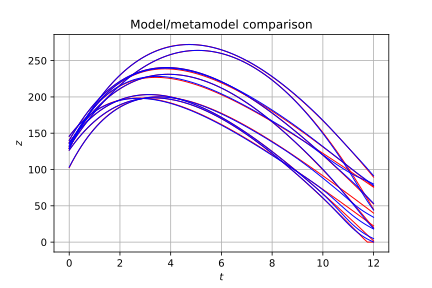

In [20]:
graph = validationOutputSample.drawMarginal(0)
graph.setColors(['red'])
graph2 = metaModel(validationInputSample).drawMarginal(0)
graph2.setColors(['blue'])
graph.add(graph2)
graph.setTitle('Model/metamodel comparison')
graph.setXTitle(r'$t$')
graph.setYTitle(r'$z$')
graph